In [41]:
import numpy as np
import matplotlib 
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [32]:
# Importing Training and Test datasets
train_data = pd.read_csv('training_data.txt', sep="\t")
test_data = pd.read_csv('testing_data.txt', sep="\t")

In [35]:
# Taking the non-linear transformation for training and testing datasets
train_data['x1_sq'] = train_data['x1']**2
train_data['x2_sq'] = train_data['x2']**2
train_data['x1_x2'] = train_data['x1']*train_data['x2']
train_data['mod_diff'] = np.absolute(train_data['x1'] - train_data['x2'])
train_data['mod_sum'] = np.absolute(train_data['x1'] + train_data['x2'])
test_data['x1_sq'] = test_data['x1']**2
test_data['x2_sq'] = test_data['x2']**2
test_data['x1_x2'] = test_data['x1']*test_data['x2']
test_data['mod_diff'] = np.absolute(test_data['x1'] - test_data['x2'])
test_data['mod_sum'] = np.absolute(test_data['x1'] + test_data['x2'])

In [44]:
# Separating the independent and dependent variables
X_train = train_data.loc[:, train_data.columns != 'y']
y_train = train_data.loc[:, train_data.columns == 'y']
X_test = test_data.loc[:, test_data.columns != 'y']
y_test = test_data.loc[:, test_data.columns == 'y']

In [45]:
# Fitting the Linear Regression Model and making predictions on the training and test datasets
regressor = LinearRegression()
regressor.fit(X_train, y_train) 
y_pred_train = regressor.predict(X_train) # Gives out numpy arrays
y_pred_test = regressor.predict(X_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
# Computing the in-sample and out of sample classification errors based on regression as PLA
err_vec_train = (y_pred_train.reshape(-1,))*((y_train.values).reshape(-1,))
err_vec_test = (y_pred_test.reshape(-1,))*((y_test.values).reshape(-1,))
print("The in-sample Classification error is: ", np.sum(err_vec_train < 0)/train_data.shape[0])
print("The out of sample Classification error is: ", np.sum(err_vec_test < 0)/test_data.shape[0])

The in-sample Classification error is:  0.0285714285714
The out of sample Classification error is:  0.08


In [55]:
# Computing the in-sample and out of sample Eucledian errors using the trained model
Ein_euclid = ((np.dot((y_pred_train - y_train.values).reshape(-1,),(y_pred_train - y_train.values).reshape(-1,)))**0.5)/train_data.shape[0]
Eout_euclid = ((np.dot((y_pred_test - y_test.values).reshape(-1,),(y_pred_test - y_test.values).reshape(-1,)))**0.5)/test_data.shape[0]
print("The eucledian in sample error is: ", Ein)
print("The eucledian out of sample error is: ", Eout)

As the training and test data sets have different number of examples it is extremely misleading to use a direct eucledian error measure to quantify the in-sample and out of sample errors that the model is making. Here it is clear that for eucledian cases Eout actually comes out to be lower than Ein !!! 

In [163]:
# Defining a function to compute the Regularized regression coefficient estimates
def regul_regress_coef(X,y,reg_param):
    """
    X: numpy array of Nxd, N - sample size/number of examples, d - dimension of the input space
    y - numpy column vector containing the responses (Nx1)
    reg_param - Regularization parameter of the form 10^k (where we are asking the user to input the value of k)
    
    Output: A column vector of estimated regression coefficients
    """
    n = X.shape[0]
    d = X.shape[1]
    X_design = np.append(np.ones((n,1)),X,axis=1)  
    a = np.linalg.inv(np.matmul(np.transpose(X_design),X_design) + (10**reg_param)*np.identity(d+1))
    b = np.dot(np.transpose(X_design),y)
    final_weight = np.dot(a,b)
    return final_weight

# Defining a function to compute the classification error (treating regression model as PLA)
def regress_class_error(X,y,weights):
    """
    X - numpy array of Nxd, N - sample size/number of examples, d - dimension of the input space
    weights - numpy column vector ((d+1)x1)
    y - numpy column vector containing the reference responses for comparing our model predictions (Nx1)
    
    Output: Classification error (proportion of misclassified points, always between 0 and 1)
    """
    n = X.shape[0]
    X = np.append(np.ones((n,1)),X,axis=1)
    y_pred = np.dot(X,weights)
    err_vec = (y_pred.reshape(-1,))*(y.reshape(-1,))
    class_err = np.sum(err_vec < 0)/X.shape[0]
    return class_err

In [164]:
# Specifying the dataset in the compatible format of numpy array
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train_design = X_train.values 
X_test_design = X_test.values
y_train_np = (y_train.values).reshape(-1,1)
y_test_np = (y_test.values).reshape(-1,1)

In [171]:
# Fitting the regularized model and computing the in-sample and out of sample classification errors
rreg_coefs = regul_regress_coef(X_train_design,y_train_np,3)
Ein_class = regress_class_error(X_train_design,y_train_np,rreg_coefs)
Eout_class = regress_class_error(X_test_design,y_test_np,rreg_coefs)
print("The in-sample Classification error is: ", Ein_class)
print("The out of sample Classification error is: ", Eout_class)

The in-sample Classification error is:  0.371428571429
The out of sample Classification error is:  0.436


<IPython.core.display.Javascript object>


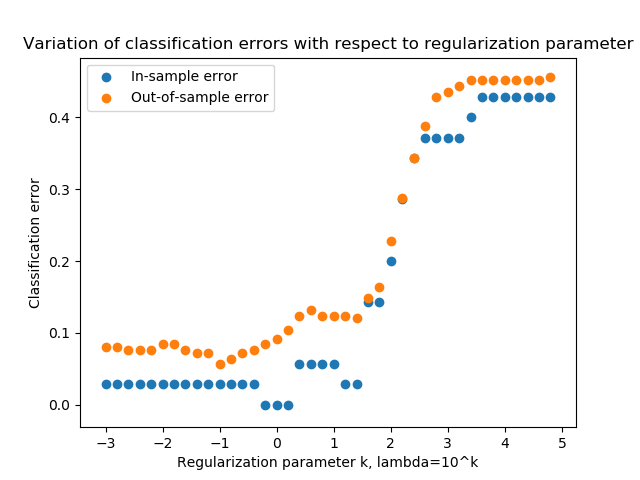

In [197]:
# PLotting the variation of in sample and out of sample error with respect to regularization parameters
fig = plt.figure() # drawing a figure with default size and color specified
ax = fig.add_subplot(111)
err_class_in = np.zeros((40,))
err_class_out = np.zeros((40,))
i = 0
reg_param_vec = np.arange(-3,5,0.2)
for k in reg_param_vec:
    rreg_coefs =  regul_regress_coef(X_train_design,y_train_np,k)
    err_class_in[i] = regress_class_error(X_train_design,y_train_np,rreg_coefs)
    err_class_out[i] = regress_class_error(X_test_design,y_test_np,rreg_coefs)
    i=i+1
    ax.set_title("Variation of classification errors with respect to regularization parameter")
    ax.set_xlabel("Regularization parameter k, lambda=10^k")
    ax.set_ylabel("Classification error")
ax.scatter(reg_param_vec,err_class_in,label="In-sample error")
ax.scatter(reg_param_vec,err_class_out,label="Out-of-sample error")
ax.legend()
plt.show()

We can see easily that the minimum Eout is observed at k=-1 and Eout keeps increasing once we over-regularize the model. For higher values of the regularization parameter our model is just suppressing the weights while estimation and no real learning is happening in that regime of parameter values. We hit the overfitting region for sometime after k=-1 where the in-sample error keeps decreasing whereas the out of sample error keeps increasing. It means that if we invoke a regularizer but fail to specify the regularization paramter correctly, overfitting still contaminates learning and we go back to square 1 !!!